In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from tqdm import tqdm

In [2]:
# set display options
pd.set_option('display.max_columns', 150)

# set seed # seed = 1->4, 42->14
seed = 23
np.random.seed(seed)
random.seed(seed)

## Que 5

### Decision Tree

In [3]:
class node():
    '''
    Represents a node in the decision tree
    '''
    def __init__(self, feature=None, thr=None, left=None, right=None, perd_label=None):
        self.feature = feature
        self.thr = thr
        self.left = left
        self.right = right
        self.perd_label = perd_label

In [4]:
class DecisionTree():
    '''
    Decision Tree Classifier
    '''
    def __init__(self, min_samples=2, max_depth=10, m_features=None):
        self.min_samples = min_samples
        self.max_depth = max_depth
        self.m_features = m_features
    
    def entropy(self, data):
        '''
        Calculate entropy of a dataset
        '''
        unique, counts = np.unique(data, return_counts=True)
        prob = counts / len(data)
        return -np.sum(prob * np.log2(prob))
    
    def info_gain(self, root, left, right):
        '''
        Calculate information gain
        '''
        wl = len(left) / len(root)
        wr = len(right) / len(root)
        return self.entropy(root) - wl * self.entropy(left) - wr * self.entropy(right)
    
    def temp_split(self, data, feature, thr):
        '''
        Split data into left and right based on threshold
        '''
        left = data[data[feature] <= thr]
        right = data[data[feature] > thr]
        return left, right
    
    def best_split(self, data):
        '''
        Find the best split
        '''
        
        # cols is list of columns indices except the last one
        cols = list(range(len(data.columns) - 1))
        
        if self.m_features is not None and self.m_features < len(cols):
            cols = random.sample(cols, self. m_features)

        best_split = {'ig': -1e9, 'feature': None, 'thr': None, 'left': None, 'right': None}
        # for idx in range(len(data.columns) - 1):
        for idx in cols:
            for thr in np.unique(data.iloc[:, idx]):
                left, right = self.temp_split(data, data.columns[idx], thr)
                if len(left) > 0 and len(right) > 0:
                    ig = self.info_gain(data.iloc[:, -1], left.iloc[:, -1], right.iloc[:, -1])
                    if ig > best_split['ig']:
                        best_split['ig'] = ig
                        best_split['feature'] = data.columns[idx]
                        best_split['thr'] = thr
                        best_split['left'] = left
                        best_split['right'] = right

        return best_split
    
    
    def set_label(self, data):
        '''
        Set the label of a node
        '''
        unique, counts = np.unique(data, return_counts=True)
        return unique[np.argmax(counts)]
    
    def build_tree(self, data, depth=0):
        '''
        Build the decision tree
        '''
        if len(data) >= self.min_samples and depth <= self.max_depth:
            split = self.best_split(data)
            if split['ig'] > 0:
                left = self.build_tree(split['left'], depth + 1)
                right = self.build_tree(split['right'], depth + 1)
                return node(feature=split['feature'], thr=split['thr'], left=left, right=right)
        
        return node(perd_label=self.set_label(data.iloc[:, -1]))
        
    def fit(self, X_train, y_train):
        '''
        Fit the model
        '''
        self.root = self.build_tree(pd.concat([X_train, y_train], axis=1))

    def predict(self, X_test):
        '''
        Predict the label
        '''
        y_pred = []
        for i in range(len(X_test)):
            node = self.root
            while node.perd_label is None:
                if X_test[node.feature].iloc[i] <= node.thr:
                    node = node.left
                else:
                    node = node.right
            y_pred.append(node.perd_label)
        return y_pred
    
    def accuracy(self, y_test, y_pred):
        '''
        Calculate accuracy
        '''
        return np.sum(y_test == y_pred) / len(y_test)   
    
# height of the tree
def height(node):
    if node is None:
        return 0
    return 1 + max(height(node.left), height(node.right))

In [5]:
list(range(10))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

## (a) Random Forest

In [6]:
class RandomForest:
    '''
    Random Forest Classifier
    '''
    def __init__(self, ratio=0.8, m_features=None, max_depth=10, min_samples=2):
        self.ratio = ratio
        self.m_features = m_features
        self.max_depth = max_depth
        self.min_samples = min_samples

    def subsample_bootstrap(self, X, y):
        '''
        Create a subsample of the dataset
        
        return: bootstrapped dataset, obb dataset
        '''
        n = len(X)
        idx = np.random.choice(n, size=int(n * self.ratio), replace=True)
        return X.iloc[idx], y.iloc[idx], X.iloc[~idx], y.iloc[~idx]    
    
    def build(self, X_train, y_train, n_trees=10):
        '''
        Build the random forest
        '''
        self.trees = []
        obb_err = []
        for i in range(n_trees):
            X_sub, y_sub, X_obb, y_obb = self.subsample_bootstrap(X_train, y_train)
            tree = DecisionTree(m_features=self.m_features, max_depth=self.max_depth, min_samples=self.min_samples)
            tree.fit(X_sub, y_sub)
            self.trees.append(tree)
            y_pred = tree.predict(X_obb)
            obb_err.append(1-tree.accuracy(y_obb, y_pred))
        return obb_err
        
    def predict(self, X_test):
        '''
        Predict the label
        '''
        y_pred = []
        for tree in self.trees:
            y_pred.append(tree.predict(X_test))
        return np.array(y_pred).T
    
    def majority_vote(self, y_pred):
        '''
        Get the majority vote
        '''
        return np.array([np.argmax(np.bincount(y_pred[i])) for i in range(len(y_pred))])

    def accuracy(self, y_test, y_pred):
        '''
        Calculate accuracy
        '''
        return np.sum(y_test == y_pred) / len(y_test)

In [7]:
def split_data(data, split_ratio=0.7):
    idx = np.random.permutation(data.index)
    split = int(split_ratio * len(data))
    # retun X_trian, y_train, X_test, y_test
    return data.iloc[idx[:split], :-1], data.iloc[idx[:split], -1], data.iloc[idx[split:], :-1], data.iloc[idx[split:], -1]

In [8]:
# load spam dataset
data = np.loadtxt("spam.data")

# split the dataset
X_train, y_train, X_test, y_test = split_data(pd.DataFrame(data), split_ratio=0.7)

In [9]:
%%time
forest = RandomForest(ratio=0.3, m_features=7, max_depth=30, min_samples=2)

# build the random forest
obb_error = forest.build(X_train, y_train, n_trees=5)

# predict the label
y_pred = forest.predict(X_test).astype(int)

# get the majority vote
y_pred = forest.majority_vote(y_pred).astype(int)

# calculate accuracy
print(forest.accuracy(y_test, y_pred))

0.9261404779145547
CPU times: user 15.8 s, sys: 9.81 ms, total: 15.8 s
Wall time: 15.8 s


In [10]:
obb_error

[0.082815734989648,
 0.08488612836438925,
 0.10351966873706009,
 0.09420289855072461,
 0.09316770186335399]

In [10]:
%%time
# sklearn random forest
clf = RandomForestClassifier(n_estimators=5, criterion='entropy')
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(accuracy_score(y_test, y_pred))

0.9348298334540188
CPU times: user 26 ms, sys: 0 ns, total: 26 ms
Wall time: 25.1 ms


## Que 5 (b)

100%|██████████| 12/12 [10:06<00:00, 50.58s/it]


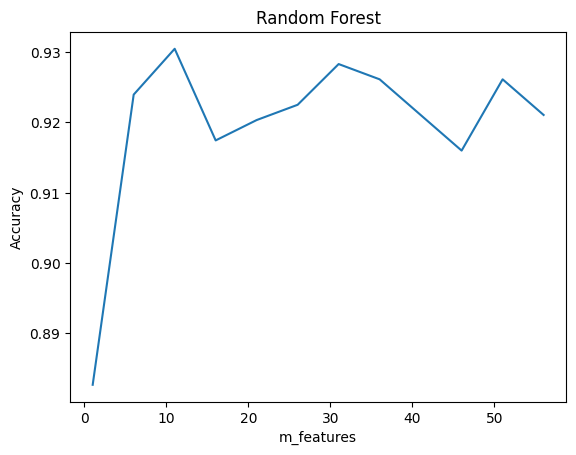

11

In [12]:
# get optimal m_features
m_features = [i for i in range(1, len(X_train.columns)+1, 5)]

acc = []
for m in tqdm(m_features):
    forest = RandomForest(ratio=0.3, m_features=m)
    forest.build(X_train, y_train, n_trees=5)
    y_pred = forest.predict(X_test).astype(int)
    y_pred = forest.majority_vote(y_pred).astype(int)
    acc.append(forest.accuracy(y_test, y_pred))

plt.plot(m_features, acc)
plt.xlabel('m_features')
plt.ylabel('Accuracy')
plt.title('Random Forest')
plt.show()

optimal_m = m_features[np.argmax(acc)]
optimal_m

100%|██████████| 57/57 [00:05<00:00, 10.86it/s]


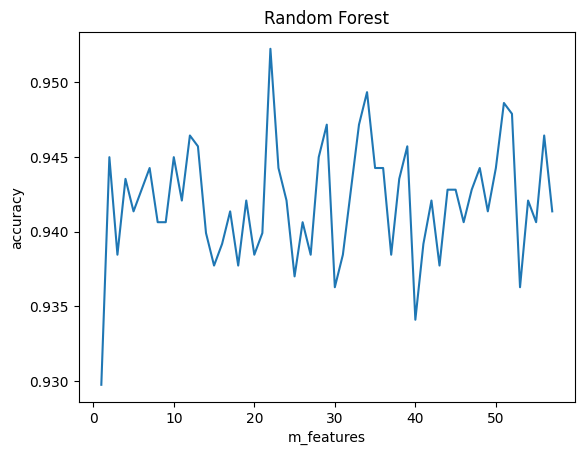

22


In [13]:
# get optimal m_features
m_features = [i for i in range(1, len(X_train.columns) + 1)]

# store the accuracy
acc = []
for m in tqdm(m_features):
    clf = RandomForestClassifier(n_estimators=10, max_features=m, criterion='entropy')
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    acc.append(accuracy_score(y_test, y_pred))

plt.plot(m_features, acc)
plt.xlabel('m_features')
plt.ylabel('accuracy')
plt.title('Random Forest')
plt.show()

# get optimal m_features, argmax
opt_m = m_features[np.argmax(acc)]
print(opt_m)


## Que 5 (c)

In [14]:
# obb score and test score 
obb_score = []
test_score = []
for n_est in tqdm(range(5, 100, 5)):
    forest = RandomForest(ratio=0.3, m_features=optimal_m)
    obb_error = forest.build(X_train, y_train, n_trees=n_est)
    y_pred = forest.predict(X_test).astype(int)
    y_pred = forest.majority_vote(y_pred).astype(int)
    test_score.append(1-forest.accuracy(y_test, y_pred))
    obb_score.append(np.mean(obb_error))

100%|██████████| 19/19 [1:04:03<00:00, 202.27s/it]


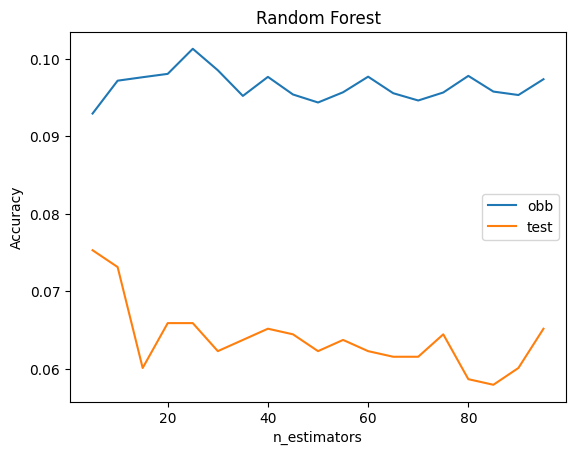

In [15]:
plt.plot(range(5, 100, 5), obb_score, label='obb')
plt.plot(range(5, 100, 5), test_score, label='test')
plt.xlabel('n_estimators')
plt.ylabel('Accuracy')
plt.title('Random Forest')
plt.legend()
plt.show()

## Que 6 (a)

In [16]:
# load data
train_data = pd.read_csv('./loan_train.csv')
test_data = pd.read_csv('./loan_test.csv')

print(f'train_data shape: {train_data.shape}')
print(f'test_data shape: {test_data.shape}')

train_data shape: (24999, 111)
test_data shape: (14718, 111)


In [17]:
# print unique values of loan_status from train_data, test_data
print(f'unique values of loan_status from train_data: {train_data["loan_status"].value_counts()}')

print(f'\nunique values of loan_status from test_data: {test_data["loan_status"].value_counts()}')

unique values of loan_status from train_data: loan_status
Fully Paid     20827
Charged Off     3474
Current          698
Name: count, dtype: int64

unique values of loan_status from test_data: loan_status
Fully Paid     12123
Charged Off     2153
Current          442
Name: count, dtype: int64


In [18]:
# print data types of columns
print(f'\ntrain_data data types: \n{train_data.dtypes.value_counts()}')

print(f'\ntest_data data types: \n{test_data.dtypes.value_counts()}')


train_data data types: 
float64    74
object     24
int64      13
Name: count, dtype: int64

test_data data types: 
float64    74
object     24
int64      13
Name: count, dtype: int64


In [19]:
# find null values count and percentage for each column
null_values_train = train_data.isnull().sum()

null_values_train = pd.DataFrame(null_values_train, columns=['null_count'])

null_values_train['null_percentage'] = null_values_train['null_count'] / train_data.shape[0] * 100

# sort null_values_train by null_percentage
null_values_train.sort_values(by='null_percentage', ascending=False, inplace=True)

# print null_values_train
print("\nnull_values_train")
print(null_values_train.head(60))

# find null values count and percentage for each column
null_values_test = test_data.isnull().sum()

null_values_test = pd.DataFrame(null_values_test, columns=['null_count'])

null_values_test['null_percentage'] = null_values_test['null_count'] / test_data.shape[0] * 100

# sort null_values_test by null_percentage
null_values_test.sort_values(by='null_percentage', ascending=False, inplace=True)

# print null_values_test
print("\nnull_values_test")
print(null_values_test.head(60))


null_values_train
                                null_count  null_percentage
verification_status_joint            24999       100.000000
annual_inc_joint                     24999       100.000000
mo_sin_old_rev_tl_op                 24999       100.000000
mo_sin_old_il_acct                   24999       100.000000
bc_util                              24999       100.000000
bc_open_to_buy                       24999       100.000000
avg_cur_bal                          24999       100.000000
acc_open_past_24mths                 24999       100.000000
inq_last_12m                         24999       100.000000
total_cu_tl                          24999       100.000000
inq_fi                               24999       100.000000
total_rev_hi_lim                     24999       100.000000
all_util                             24999       100.000000
max_bal_bc                           24999       100.000000
open_rv_24m                          24999       100.000000
open_rv_12m          

In [20]:
# drop columns that have more than 20% missing values
train_data = train_data.drop(columns=null_values_train[null_values_train['null_percentage'] > 20].index)

test_data = test_data.drop(columns=null_values_test[null_values_test['null_percentage'] > 20].index)

In [21]:
# print unique values in columns with dtype object
tp = 10
print(f"\ntop {tp} unique values in columns with dtype object\n")
for col in train_data.select_dtypes(include='object').columns:
    # print(f'{col}: {train_data[col].unique()}')
    print(f'{col}: {len(train_data[col].unique())} different values \n {train_data[col].unique()[:tp]}\n')
    
train_data.describe(include='object')


top 10 unique values in columns with dtype object

term: 2 different values 
 [' 36 months' ' 60 months']

int_rate: 361 different values 
 ['7.51%' '8.94%' '13.57%' '20.89%' '17.49%' '7.88%' '14.91%' '7.90%'
 '11.71%' '12.53%']

grade: 7 different values 
 ['A' 'C' 'F' 'D' 'B' 'E' 'G']

sub_grade: 35 different values 
 ['A4' 'A5' 'C3' 'F1' 'D5' 'D2' 'B3' 'B5' 'C2' 'C1']

emp_title: 19953 different values 
 ['15' '1400' '36000' '553742017' '  old palm inc'
 ' Brocade Communications' ' CenturyLink'
 ' Department of Homeland Security' ' Down To Earth Distributors, Inc.'
 ' pacific crane maintenance company']

emp_length: 12 different values 
 ['10+ years' '1 year' '4 years' '5 years' '7 years' '6 years' '2 years'
 '8 years' '< 1 year' '3 years']

home_ownership: 4 different values 
 ['RENT' 'OWN' 'MORTGAGE' 'OTHER']

verification_status: 3 different values 
 ['Source Verified' 'Not Verified' 'Verified']

issue_d: 55 different values 
 ['10-Sep' '10-Jan' '9-Oct' '11-Nov' '11-Jul' '9-Dec'

,term,int_rate,grade,sub_grade,emp_title,emp_length,home_ownership,verification_status,issue_d,loan_status,pymnt_plan,url,purpose,title,zip_code,addr_state,earliest_cr_line,revol_util,initial_list_status,last_pymnt_d,last_credit_pull_d,application_type
count,24999,24999,24999,24999,24993,24958,24999,24999,24999,24999,24999,24999,24999,24991,24999,24999,24999,24970,24999,24954,24999,24999
unique,2,361,7,35,19952,11,4,3,55,3,1,24999,14,12893,787,50,495,1059,1,101,102,1
top,36 months,10.99%,B,A4,Bank of America,10+ years,RENT,Not Verified,11-Dec,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,debt_consolidation,Debt Consolidation,100xx,CA,Nov-98,0%,f,16-May,16-May,INDIVIDUAL
freq,18203,602,7497,1831,109,5565,12034,10762,1426,20827,24999,1,11932,1407,409,4414,246,606,24999,769,6530,24999


Convert object columns to category

In [22]:
# term
train_data['term'] = train_data['term'].str.extract('(\d+)').astype('int')
test_data['term'] = test_data['term'].str.extract('(\d+)').astype('int')

# int_rate
train_data['int_rate'] = train_data['int_rate'].str.extract('(\d+\.\d+)').astype('float')
test_data['int_rate'] = test_data['int_rate'].str.extract('(\d+\.\d+)').astype('float')

In [23]:
# grade
train_data['grade'] = train_data['grade'].map({'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6})
test_data['grade'] = test_data['grade'].map({'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6})

# sub_grade -> drop col

# emp_title -> drop col

# emp_length
train_data['emp_length'] = train_data['emp_length'].map({'< 1 year': 0, '1 year': 1, '2 years': 2, '3 years': 3, '4 years': 4, '5 years': 5, '6 years': 6, '7 years': 7, '8 years': 8, '9 years': 9, '10+ years': 10})
test_data['emp_length'] = test_data['emp_length'].map({'< 1 year': 0, '1 year': 1, '2 years': 2, '3 years': 3, '4 years': 4, '5 years': 5, '6 years': 6, '7 years': 7, '8 years': 8, '9 years': 9, '10+ years': 10})

# home_ownership
train_data['home_ownership'] = train_data['home_ownership'].map({'MORTGAGE': 0, 'RENT': 1, 'OWN': 2, 'ANY': 3, 'OTHER': 3, 'NONE': 3})
test_data['home_ownership'] = test_data['home_ownership'].map({'MORTGAGE': 0, 'RENT': 1, 'OWN': 2, 'ANY': 3, 'OTHER': 3, 'NONE': 3})

# verification_status
train_data['verification_status'] = train_data['verification_status'].map({'Not Verified': 0, 'Source Verified': 1, 'Verified': 2})
test_data['verification_status'] = test_data['verification_status'].map({'Not Verified': 0, 'Source Verified': 1, 'Verified': 2})

# issue_d -> drop col

# loan_status -> target col
train_data = train_data[train_data['loan_status'].isin(['Fully Paid', 'Charged Off'])]
train_data['loan_status'] = train_data['loan_status'].map({'Fully Paid': 1, 'Charged Off': -1})

test_data = test_data[test_data['loan_status'].isin(['Fully Paid', 'Charged Off'])]
test_data['loan_status'] = test_data['loan_status'].map({'Fully Paid': 1, 'Charged Off': -1})

# pymnt_plan -> drop col

# url -> drop col

# purpose -> drop col

# title -> drop col

# zip_code -> drop col

# addr_state -> drop col

# earliest_cr_line -> drop col

# revol_util -> drop col

# initial_list_status -> drop col

# last_pymnt_d -> drop col

# last_credit_pull_d -> drop col

# application_type -> drop col

In [24]:
# drop columns of less use with dtpye object
cols = ["sub_grade", "emp_title", "issue_d", "pymnt_plan", "url", "purpose", "title", "zip_code", "addr_state", "earliest_cr_line", "revol_util", "initial_list_status", "last_pymnt_d", "last_credit_pull_d", "application_type"]
train_data = train_data.drop(columns=cols)
test_data = test_data.drop(columns=cols)

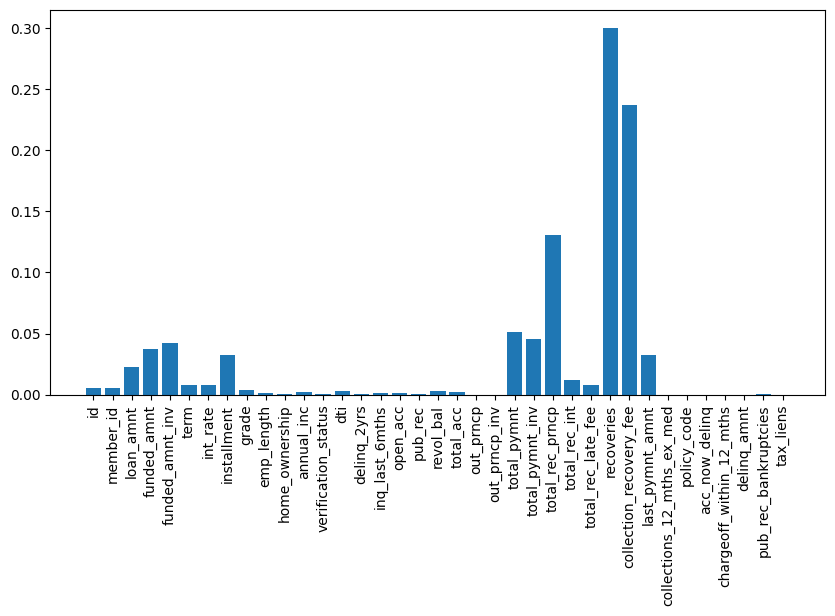

In [25]:
# use random forest for feature importance

X = train_data.drop(columns=['loan_status'])
y = train_data['loan_status']

rf = RandomForestClassifier(n_estimators=100, random_state=seed)
rf.fit(X, y)

# plot feature importance
plt.figure(figsize=(10, 5))
plt.bar(X.columns, rf.feature_importances_)
plt.xticks(rotation=90)
plt.show()


In [26]:
# drop columns with importance less than 0.0003
cols = X.columns[rf.feature_importances_ < 0.0003]
train_data = train_data.drop(columns=cols)
test_data = test_data.drop(columns=cols)

# drop id, member_id cols as they are not useful
train_data = train_data.drop(columns=['id', 'member_id'])
test_data = test_data.drop(columns=['id', 'member_id'])


In [27]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 24301 entries, 0 to 24998
Data columns (total 28 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   loan_amnt                24301 non-null  int64  
 1   funded_amnt              24301 non-null  int64  
 2   funded_amnt_inv          24301 non-null  float64
 3   term                     24301 non-null  int64  
 4   int_rate                 24301 non-null  float64
 5   installment              24301 non-null  float64
 6   grade                    24301 non-null  int64  
 7   emp_length               24261 non-null  float64
 8   home_ownership           24301 non-null  int64  
 9   annual_inc               24301 non-null  float64
 10  verification_status      24301 non-null  int64  
 11  loan_status              24301 non-null  int64  
 12  dti                      24301 non-null  float64
 13  delinq_2yrs              24301 non-null  int64  
 14  inq_last_6mths           24

In [28]:
# replace missing values with median
train_data = train_data.fillna(train_data.median())

test_data = test_data.fillna(test_data.median())


## Que 6 (b)

In [29]:
def get_metrics(learning_rate=0.1, n_estimators=100, max_depth=3):
    gb = GradientBoostingClassifier(learning_rate=learning_rate, n_estimators=n_estimators, max_depth=max_depth, random_state=seed)
    gb.fit(X, y)
    y_pred = gb.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = np.sum((y_test == 1) & (y_pred == 1)) / np.sum(y_pred == 1)
    recall = np.sum((y_test == 1) & (y_pred == 1)) / np.sum(y_test == 1)
    return accuracy, precision, recall

In [30]:
# gradient boosting
X = train_data.drop(columns=['loan_status'])
y = train_data['loan_status']

X_test = test_data.drop(columns=['loan_status'])
y_test = test_data['loan_status']

accuracy, precision, recall = get_metrics(n_estimators=100)

print(f'accuracy: {accuracy}')
print(f'precision: {precision}')
print(f'recall: {recall}')

accuracy: 0.9946763799383581
precision: 0.9938509469541691
recall: 0.9999175121669553


In [31]:
# hyperparameter tuning -> learning_rate, n_estimators, max_depth
learning_rates = [0.001, 0.01, 0.05, 0.1, 0.15, 0.2]

accuracies = []
for learning_rate in learning_rates:
    accuracy, precision, recall = get_metrics(learning_rate=learning_rate)
    accuracies.append(accuracy)
    print(f'learning_rate: {learning_rate}, accuracy: {accuracy}, precision: {precision}, recall: {recall}')

lr = learning_rates[np.argmax(accuracies)]

print(f'best learning_rate: {lr}')
print(f'best accuracy: {np.max(accuracies)}')

learning_rate: 0.001, accuracy: 0.8491874474642757, precision: 0.8491874474642757, recall: 1.0
learning_rate: 0.01, accuracy: 0.97219108994116, precision: 0.9682907348242812, recall: 1.0
learning_rate: 0.05, accuracy: 0.9899831885682264, precision: 0.9883417577042231, recall: 1.0
learning_rate: 0.1, accuracy: 0.9946763799383581, precision: 0.9938509469541691, recall: 0.9999175121669553
learning_rate: 0.15, accuracy: 0.9954469038946484, precision: 0.9949105237235265, recall: 0.9997525365008662
learning_rate: 0.2, accuracy: 0.9962174278509386, precision: 0.9957282510474, recall: 0.9998350243339107
best learning_rate: 0.2
best accuracy: 0.9962174278509386


In [32]:
# hyperparameter tuning -> n_estimators
n_estimators = [50, 100, 200, 300, 500, 700, 1000, 1250, 1500, 1700]

accuracies = []
for n_estimator in n_estimators:
    accuracy, precision, recall = get_metrics(learning_rate=lr, n_estimators=n_estimator)
    accuracies.append(accuracy)
    print(f'n_estimator: {n_estimator}, accuracy: {accuracy}, precision: {precision}, recall: {recall}')

ne = n_estimators[np.argmax(accuracies)]

print(f'best n_estimator: {ne}')
print(f'best accuracy: {np.max(accuracies)}')


n_estimator: 50, accuracy: 0.9950966657326983, precision: 0.9943400869493889, recall: 0.9999175121669553
n_estimator: 100, accuracy: 0.9962174278509386, precision: 0.9957282510474, recall: 0.9998350243339107
n_estimator: 200, accuracy: 0.9972681423367891, precision: 0.996875, recall: 0.9999175121669553
n_estimator: 300, accuracy: 0.9974782852339591, precision: 0.9971210002467714, recall: 0.9999175121669553
n_estimator: 500, accuracy: 0.9976884281311291, precision: 0.9973671219351654, recall: 0.9999175121669553
n_estimator: 700, accuracy: 0.9977584757635192, precision: 0.9974491895005348, recall: 0.9999175121669553
n_estimator: 1000, accuracy: 0.9979686186606893, precision: 0.9976954732510288, recall: 0.9999175121669553
n_estimator: 1250, accuracy: 0.9981087139254693, precision: 0.9978597299967072, recall: 0.9999175121669553
n_estimator: 1500, accuracy: 0.9981087139254693, precision: 0.9978597299967072, recall: 0.9999175121669553
n_estimator: 1700, accuracy: 0.9981087139254693, precisio

In [33]:
max_depths = [3, 5, 7, 9]

accuracies = []
for max_depth in max_depths:
    accuracy, precision, recall = get_metrics(learning_rate=lr, n_estimators=ne, max_depth=max_depth)
    accuracies.append(accuracy)
    print(f'max_depth: {max_depth}, accuracy: {accuracy}, precision: {precision}, recall: {recall}')

md = max_depths[np.argmax(accuracies)]

print(f'best max_depth: {md}')
print(f'best accuracy: {np.max(accuracies)}')


max_depth: 3, accuracy: 0.9981087139254693, precision: 0.9978597299967072, recall: 0.9999175121669553
max_depth: 5, accuracy: 0.9982488091902494, precision: 0.997942048073757, recall: 1.0
max_depth: 7, accuracy: 0.9982488091902494, precision: 0.997942048073757, recall: 1.0
max_depth: 9, accuracy: 0.9981087139254693, precision: 0.9977777777777778, recall: 1.0
best max_depth: 5
best accuracy: 0.9982488091902494


In [34]:
# decision tree
dt = DecisionTreeClassifier(random_state=seed, criterion='entropy')
dt.fit(X, y)

y_pred = dt.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f'accuracy: {accuracy}')

precision = np.sum((y_test == 1) & (y_pred == 1)) / np.sum(y_pred == 1)
print(f'precision: {precision}')

recall = np.sum((y_test == 1) & (y_pred == 1)) / np.sum(y_test == 1)
print(f'recall: {recall}')

accuracy: 0.9969179041748389
precision: 0.9979388243053838
recall: 0.9984327311721521
